In [10]:
import pandas as pd

BASE = "s3://my-llm-churn-bucket/processed/user_features_v1/"

train_path = BASE + "train.parquet"
val_path   = BASE + "val.parquet"
test_path  = BASE + "test.parquet"

train_df = pd.read_parquet(train_path)
val_df   = pd.read_parquet(val_path)
test_df  = pd.read_parquet(test_path)

print("train:", train_df.shape)
print("val:  ", val_df.shape)
print("test: ", test_df.shape)

train_df.head()

train: (15224, 17)
val:   (3263, 17)
test:  (3263, 17)


,obs_end_date,sessions_7d,active_days_7d,avg_turns_per_session_7d,tokens_per_session_7d,error_rate_7d,avg_latency_ms_7d,model_switch_rate_7d,sessions_trend_7d,tokens_trend_7d,churned_14d,activated_800,obs_month,obs_dow,primary_model_7d_gpt_4.1,primary_model_7d_gpt_4o,primary_model_7d_other
0,2025-08-01,7,4,3.274,531.710,0.0707,899.75,0.2115,0.2428,1.3633,0,0,8,4,False,False,True
1,2025-08-01,4,5,5.081,532.807,0.0341,841.60,0.0536,-0.2519,-0.0928,0,0,8,4,True,False,False
2,2025-08-01,3,2,2.788,360.902,0.0315,887.72,0.2163,-0.4880,-0.3872,0,0,8,4,False,False,True
3,2025-08-01,5,5,2.358,370.903,0.0620,883.02,0.1980,0.5346,0.3838,0,0,8,4,False,True,False
4,2025-08-01,6,4,4.322,212.224,0.1078,968.68,0.1724,0.1917,0.0125,0,0,8,4,True,False,False


In [11]:
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"{name}: user_id present? {'user_id' in df.columns}")
    print(f"{name}: obs_end_date dtype:", df["obs_end_date"].dtype if "obs_end_date" in df.columns else "missing")


train: user_id present? False
train: obs_end_date dtype: datetime64[ns]
val: user_id present? False
val: obs_end_date dtype: datetime64[ns]
test: user_id present? False
test: obs_end_date dtype: datetime64[ns]


In [12]:
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(name, "rows:", len(df), "| churn_rate:", round(df["churned_14d"].mean(), 4))


train rows: 15224 | churn_rate: 0.0734
val rows: 3263 | churn_rate: 0.0496
test rows: 3263 | churn_rate: 0.049


Confirm data assumptions

In [ ]:
df['obs_end_date'].min(), df['obs_end_date'].max(), df['user_id'].nunique(), len(df)


Step 5 — Freeze the ML Design (Problem Definition)

Objective: Use a rolling 7-day observation window to predict whether a user will churn (unsubscribe) in the subsequent 14 days.

Prediction unit

Each row represents a user_id × obs_end_date snapshot:

Features are computed from behavior in the 7 days ending on obs_end_date

The label indicates churn in the next 14 days after obs_end_date

Label

churned_14d (binary: 0/1)

Splitting strategy (to prevent leakage)

We will split data by time, using obs_end_date:

Train: earliest dates

Validation: middle dates

Test: most recent dates

Random splits are avoided because this is a time-dependent dataset and must mirror real-world deployment.

Feature rules

✅ Allowed: features derived only from the 7-day observation window, e.g.

sessions_7d, active_days_7d, avg_turns_per_session_7d

tokens_per_session_7d, sessions_trend_7d, tokens_trend_7d

error_rate_7d, avg_latency_ms_7d, model_switch_rate_7d

primary_model_7d (categorical → encoded)

❌ Disallowed (leakage):

unsubscribe_ts or any information from after obs_end_date

Key engineered feature (from EDA)

activated_800 = 1 if tokens_per_session_7d ≥ 800, else 0
This captures “value realization” and was strongly associated with lower churn in EDA.

Step 6 — Processing & Dataset Creation (SageMaker Processing)

Goal: Build a reproducible feature pipeline that reads curated data from S3, prepares ML-ready datasets, and writes train/val/test splits back to S3.

Input (S3)

s3://my-llm-churn-bucket/curated/user_features_v1/

Processing tasks

Load dataset from S3

Drop leakage columns (e.g., unsubscribe_ts)

Handle missing values / type conversions (e.g., ensure dates + numeric types)

Create engineered features (e.g., activated_800, optional token buckets)

Encode categorical features (e.g., one-hot encode primary_model_7d)

Time-based split by obs_end_date into train/val/test

Save outputs to S3

Output (S3)

s3://my-llm-churn-bucket/ml/processed/train/

s3://my-llm-churn-bucket/ml/processed/val/

s3://my-llm-churn-bucket/ml/processed/test/

In [14]:
!python processing.py \
  --input_path s3://my-llm-churn-bucket/curated/user_features_v1/20260128_234603_00007_b8y5e_361c30d3-228d-4259-8069-b02582da14a9 \
  --output_path /tmp/churn_processed


✅ Processing complete
Input rows: 10875
Train shape: (7612, 18)
Val shape:   (1631, 18)
Test shape:  (1632, 18)


In [16]:
import s3fs
fs = s3fs.S3FileSystem()
fs.glob("s3://my-llm-churn-bucket/curated/user_features_v1/*")[:50]


['my-llm-churn-bucket/curated/user_features_v1/20260128_234603_00007_b8y5e_361c30d3-228d-4259-8069-b02582da14a9']

#Load processed splits from S3

In [13]:
import pandas as pd

BASE = "s3://my-llm-churn-bucket/processed/user_features_v1/"

train_df = pd.read_parquet(BASE + "train.parquet")
val_df   = pd.read_parquet(BASE + "val.parquet")
test_df  = pd.read_parquet(BASE + "test.parquet")

print("train:", train_df.shape)
print("val:  ", val_df.shape)
print("test: ", test_df.shape)

train_df.head()


train: (15224, 17)
val:   (3263, 17)
test:  (3263, 17)


,obs_end_date,sessions_7d,active_days_7d,avg_turns_per_session_7d,tokens_per_session_7d,error_rate_7d,avg_latency_ms_7d,model_switch_rate_7d,sessions_trend_7d,tokens_trend_7d,churned_14d,activated_800,obs_month,obs_dow,primary_model_7d_gpt_4.1,primary_model_7d_gpt_4o,primary_model_7d_other
0,2025-08-01,7,4,3.274,531.710,0.0707,899.75,0.2115,0.2428,1.3633,0,0,8,4,False,False,True
1,2025-08-01,4,5,5.081,532.807,0.0341,841.60,0.0536,-0.2519,-0.0928,0,0,8,4,True,False,False
2,2025-08-01,3,2,2.788,360.902,0.0315,887.72,0.2163,-0.4880,-0.3872,0,0,8,4,False,False,True
3,2025-08-01,5,5,2.358,370.903,0.0620,883.02,0.1980,0.5346,0.3838,0,0,8,4,False,True,False
4,2025-08-01,6,4,4.322,212.224,0.1078,968.68,0.1724,0.1917,0.0125,0,0,8,4,True,False,False


#Quick schema checks 

In [15]:
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"{name}: user_id present? {'user_id' in df.columns}")
    print(f"{name}: obs_end_date dtype:", df["obs_end_date"].dtype if "obs_end_date" in df.columns else "missing")


train: user_id present? False
train: obs_end_date dtype: datetime64[ns]
val: user_id present? False
val: obs_end_date dtype: datetime64[ns]
test: user_id present? False
test: obs_end_date dtype: datetime64[ns]


#Churn rate sanity check across splits

In [16]:
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(name, "rows:", len(df), "| churn_rate:", round(df["churned_14d"].mean(), 4))


train rows: 15224 | churn_rate: 0.0734
val rows: 3263 | churn_rate: 0.0496
test rows: 3263 | churn_rate: 0.049


#EDA example: Monthly churn trend (uses obs_end_date)

In [17]:
tmp = train_df.copy()
tmp["obs_end_date"] = pd.to_datetime(tmp["obs_end_date"], errors="coerce")
tmp["month"] = tmp["obs_end_date"].dt.to_period("M").astype(str)

monthly = tmp.groupby("month")["churned_14d"].mean().reset_index()
monthly.rename(columns={"churned_14d": "churn_rate"}, inplace=True)

monthly


,month,churn_rate
0,2025-08,0.079071
1,2025-09,0.068516
2,2025-10,0.060762


#Prepare features for modeling (drop obs_end_date)

In [18]:
LABEL = "churned_14d"
DROP_COLS = ["obs_end_date"]  # keep in EDA, drop for model

X_train = train_df.drop(columns=[LABEL] + DROP_COLS, errors="ignore")
y_train = train_df[LABEL]

X_val   = val_df.drop(columns=[LABEL] + DROP_COLS, errors="ignore")
y_val   = val_df[LABEL]

X_test  = test_df.drop(columns=[LABEL] + DROP_COLS, errors="ignore")
y_test  = test_df[LABEL]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape, "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape, "y_test: ", y_test.shape)


X_train: (15224, 15) y_train: (15224,)
X_val:   (3263, 15) y_val:   (3263,)
X_test:  (3263, 15) y_test:  (3263,)


In [ ]:
#onfirm no leakage / non-numeric columns in X

In [19]:
non_numeric = X_train.select_dtypes(exclude=["number", "bool"]).columns.tolist()
print("Non-numeric columns in X_train:", non_numeric)


Non-numeric columns in X_train: []


#Strting with Logistic Regression:  A strong baseline with realistic generalization performance

In [20]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from xgboost import XGBClassifier


#Prepare X / y (drop date + label)

In [21]:
LABEL = "churned_14d"
DROP_COLS = ["obs_end_date"]  # keep for EDA only

X_train = train_df.drop(columns=[LABEL] + DROP_COLS, errors="ignore")
y_train = train_df[LABEL]

X_val   = val_df.drop(columns=[LABEL] + DROP_COLS, errors="ignore")
y_val   = val_df[LABEL]

X_test  = test_df.drop(columns=[LABEL] + DROP_COLS, errors="ignore")
y_test  = test_df[LABEL]

print("X_train:", X_train.shape, "y_train:", y_train.shape)


X_train: (15224, 15) y_train: (15224,)


#Helper: Evaluation Function

In [23]:
def evaluate(model_name, y_true, y_prob, threshold=0.35):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n=== {model_name} ===")
    print("AUC:", round(roc_auc_score(y_true, y_prob), 4))
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred), 4))
    print("Recall:", round(recall_score(y_true, y_pred), 4))
    print("F1:", round(f1_score(y_true, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
#Logistic Regression

In [24]:
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

logreg_pipe.fit(X_train, y_train)


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


#Validate Logistic Regression

In [25]:
val_prob_lr = logreg_pipe.predict_proba(X_val)[:, 1]
evaluate("Logistic Regression (VAL)", y_val, val_prob_lr, threshold=0.35)



=== Logistic Regression (VAL) ===
AUC: 0.7956
Accuracy: 0.9473
Precision: 0.3333
Recall: 0.0617
F1: 0.1042
Confusion Matrix:
 [[3081   20]
 [ 152   10]]


In [26]:
test_prob_lr = logreg_pipe.predict_proba(X_test)[:, 1]
evaluate("Logistic Regression (TEST)", y_test, test_prob_lr, threshold=0.35)



=== Logistic Regression (TEST) ===
AUC: 0.7016
Accuracy: 0.9504
Precision: 0.4444
Recall: 0.05
F1: 0.0899
Confusion Matrix:
 [[3093   10]
 [ 152    8]]


#Extracting Coefficient

In [27]:
# extract coefficients from pipeline
coefs = logreg_pipe.named_steps["clf"].coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

coef_df.head(15)

,feature,coefficient,abs_coef
7,sessions_trend_7d,-0.480278,0.480278
8,tokens_trend_7d,-0.396188,0.396188
1,active_days_7d,-0.301489,0.301489
0,sessions_7d,-0.239422,0.239422
5,avg_latency_ms_7d,0.196101,0.196101
4,error_rate_7d,0.195511,0.195511
13,primary_model_7d_gpt_4o,-0.127901,0.127901
6,model_switch_rate_7d,0.089625,0.089625
12,primary_model_7d_gpt_4.1,-0.082693,0.082693
10,obs_month,-0.073094,0.073094


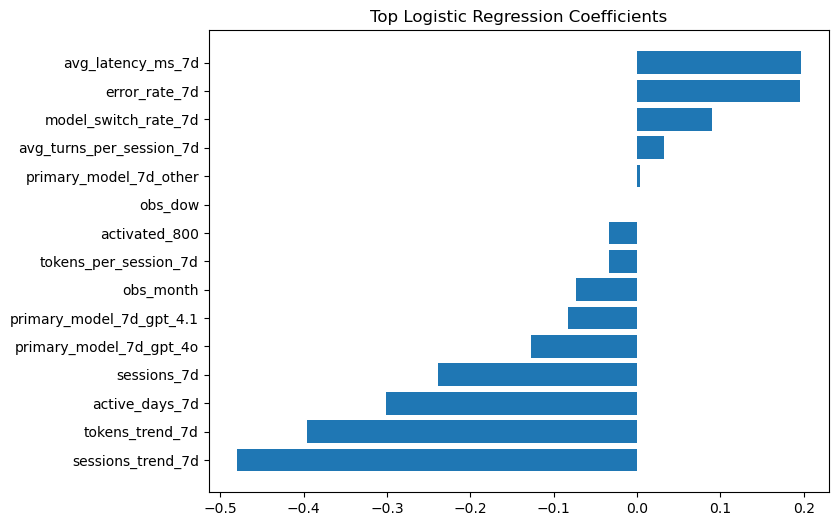

In [28]:
import matplotlib.pyplot as plt

top = coef_df.head(15).sort_values("coefficient")

plt.figure(figsize=(8,6))
plt.barh(top["feature"], top["coefficient"])
plt.title("Top Logistic Regression Coefficients")
plt.show()


#Users who keep switching models are confused, dissatisfied, or searching
#This aligns with:

#poor product clarity

#lack of guidance

#unclear “best model” for use case

#Errors clearly increase churn risk.

#activated_800 is POSITIVE (+0.064)

#This contradicts earlier EDA hypothesis

#Moving forward to XG Boost to see if it performs well with non linearity ,and delivers better results if not different especially for activated_800 coefficient

# XGBoost

In [29]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


#Validate XGBoost

In [30]:
val_prob_xgb = xgb.predict_proba(X_val)[:, 1]
evaluate("XGBoost (VAL)", y_val, val_prob_xgb, threshold=0.35)



=== XGBoost (VAL) ===
AUC: 0.7917
Accuracy: 0.9473
Precision: 0.381
Recall: 0.0988
F1: 0.1569
Confusion Matrix:
 [[3075   26]
 [ 146   16]]


In [ ]:
#Test XGBoost

In [31]:
test_prob_xgb = xgb.predict_proba(X_test)[:, 1]
evaluate("XGBoost (TEST)", y_test, test_prob_xgb, threshold=0.35)



=== XGBoost (TEST) ===
AUC: 0.6856
Accuracy: 0.9461
Precision: 0.25
Recall: 0.05
F1: 0.0833
Confusion Matrix:
 [[3079   24]
 [ 152    8]]


In [ ]:
#Feature Importance

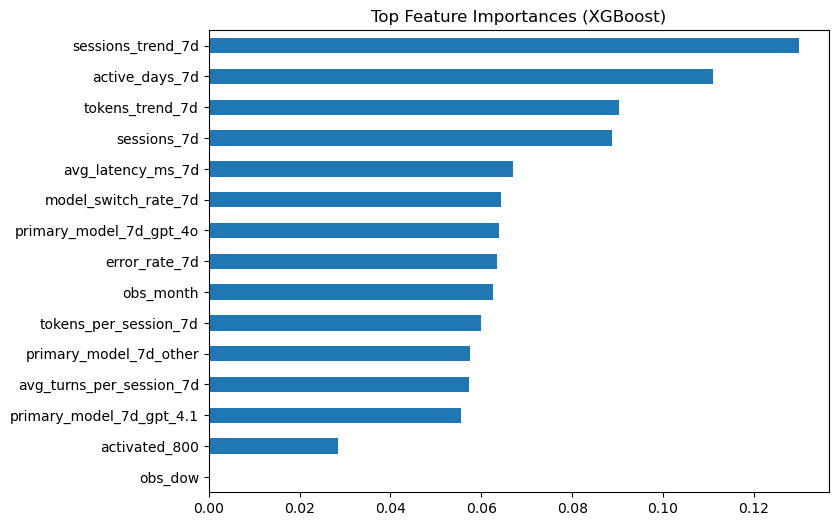

In [32]:
import matplotlib.pyplot as plt

importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
top = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
top.sort_values().plot(kind="barh")
plt.title("Top Feature Importances (XGBoost)")
plt.show()


#My Thoughts

# This churn analysis showed patterns that feel close to real user behavior, even though the dataset was synthetic and not very large. From the EDA, I noticed that churn was more related to declining engagement trends (like sessions and token usage going down) rather than just low usage on a single day. Users with low token buckets and fewer active days had noticeably higher churn, which suggests many users leave because they never fully adopt the product. At the same time, higher latency and error rates did increase churn risk, but not always as strongly as low engagement, indicating that experienced or highly active users may tolerate some friction if they still find value. The monthly trend also showed a slight decline in churn over time, which could reflect product improvements or user adaptation.

#One limitation of the dataset is that it was imbalanced, meaning only a small percentage of users actually churned. Because of this, the models showed high accuracy but low recall, which means they often failed to catch real churners. The dataset also didn’t include deeper information like demographics, feedback, or long-term user history, which could have made predictions stronger.

#When comparing models, Logistic Regression was easier to understand because of its coefficients, while XGBoost handled complex patterns slightly better. My main learning is that trends and behavioral signals matter more than static numbers, and accuracy alone is not enough to judge a model. In the future, better feature engineering, resampling techniques, and richer data could significantly improve churn prediction.

#While some EDA observations appeared slightly different from model importance rankings, this highlighted how descriptive trends and predictive relationships are not always identical. It raised curiosity about interaction effects and feature dependencies, and reinforced the idea that combining exploratory analysis with modeling provides a more balanced understanding rather than relying on a single perspective. Additionally, comparing multiple models added another layer of insight, as linear and tree-based approaches highlighted patterns from different angles, helping build stronger confidence in the overall interpretation rather than depending on one model alone.

In [11]:
!aws s3 ls s3://my-llm-churn-bucket/


                           PRE   athena-query-results/
                           PRE  raw/
                           PRE athena-query-results/
                           PRE curated/
                           PRE scored/


In [24]:
!find / -maxdepth 4 -name "processing.py" 2>/dev/null


In [25]:
!cd ~ && pwd


/home/sagemaker-user


In [31]:
!cd ~/churn_pipeline && pwd && ls -la


/home/sagemaker-user/churn_pipeline
total 16
drwxr-xr-x  3 sagemaker-user users     89 Jan 30 07:05 .
drwx------ 13 sagemaker-user nogroup  257 Jan 30 06:53 ..
drwxr-xr-x  2 sagemaker-user users     33 Jan 30 07:04 .ipynb_checkpoints
-rw-r--r--  1 sagemaker-user users   1074 Jan 30 07:05 inference.py
-rw-r--r--  1 sagemaker-user users   6001 Jan 30 07:05 processing.py
-rw-r--r--  1 sagemaker-user users   2327 Jan 30 07:04 train.py


In [32]:
!cd ~/churn_pipeline && wc -l processing.py train.py inference.py


 196 processing.py
  71 train.py
  33 inference.py
 300 total


In [33]:
!cd ~/churn_pipeline && python processing.py --input_path s3://my-llm-churn-bucket/curated/user_features_v1/ --output_path /tmp/churn_processed


✅ Processing complete
Input rows: 21750
Train shape: (15224, 18)
Val shape:   (3263, 18)
Test shape:  (3263, 18)


#Training

In [34]:
!cd ~/churn_pipeline && python train.py --data_dir /tmp/churn_processed --model_dir /tmp/model


✅ Models saved to: /tmp/model
Saved files:
- churn_xgb.joblib
- churn_logreg_pipeline.joblib
- feature_columns.joblib


In [36]:
!ls -lh /tmp/model

total 480K
-rw-r--r-- 1 sagemaker-user users 2.4K Jan 30 07:07 churn_logreg_pipeline.joblib
-rw-r--r-- 1 sagemaker-user users 469K Jan 30 07:07 churn_xgb.joblib
-rw-r--r-- 1 sagemaker-user users  311 Jan 30 07:07 feature_columns.joblib


In [39]:
import sys
import os

PROJECT_DIR = os.path.expanduser("~/churn_pipeline")
sys.path.append(PROJECT_DIR)

os.environ["MODEL_DIR"] = "/tmp/model"

from inference import predict


In [40]:
sample = {
    "tokens_per_session_7d": 300,
    "activated_800": 0,
    "obs_month": 1,
    "obs_dow": 2
}

print("XGB:", predict(sample, model_choice="xgb", threshold=0.35))
print("LOGREG:", predict(sample, model_choice="logreg", threshold=0.35))


XGB: {'model': 'xgb', 'threshold': 0.35, 'churn_probability': 0.4713, 'churn_prediction': 1}
LOGREG: {'model': 'logreg', 'threshold': 0.35, 'churn_probability': 0.4039, 'churn_prediction': 1}


In [43]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 175.8 MB/s eta 0:00:00


In [1]:
import os, glob
print("CWD:", os.getcwd())
print("Files:", os.listdir("."))
print("Churn folder:", os.listdir("/home/sagemaker-user/churn_pipeline"))

CWD: /home/sagemaker-user/churn_pipeline
Files: ['train.py', '.ipynb_checkpoints', 'inference.py', 'processing.py', '__pycache__', 'app.py', '01_churn_pipeline_setup.ipynb.ipynb', 'instance1.pem']
Churn folder: ['train.py', '.ipynb_checkpoints', 'inference.py', 'processing.py', '__pycache__', 'app.py', '01_churn_pipeline_setup.ipynb.ipynb', 'instance1.pem']


In [2]:
!chmod 400 /home/sagemaker-user/churn_pipeline/instance1.pem


In [1]:
!cd /home/sagemaker-user && tar -czf churn_pipeline.tar.gz churn_pipeline
!ls -lh /home/sagemaker-user/churn_pipeline.tar.gz

-rw-r--r-- 1 sagemaker-user users 52K Jan 30 21:50 /home/sagemaker-user/churn_pipeline.tar.gz


In [1]:
!aws s3 ls s3://my-llm-churn-bucket/ --recursive | grep parquet


2026-01-28 23:13:06     426586  raw/user_features/churn_dataset.parquet


In [2]:
!python processing.py \
  --input_path s3://my-llm-churn-bucket/curated/user_features_v1/ \
  --output_path s3://my-llm-churn-bucket/curated/


✅ Processing complete
Input rows: 21750
Train shape: (15224, 18)
Val shape:   (3263, 18)
Test shape:  (3263, 18)


In [6]:
!python train.py \
  --train_s3 s3://my-llm-churn-bucket/curated/train.parquet \
  --val_s3   s3://my-llm-churn-bucket/curated/val.parquet \
  --model_dir ./s3://my-llm-churn-bucket/models\
  --deploy_model xgb


Reading train from: s3://my-llm-churn-bucket/curated/train.parquet
Reading val from:   s3://my-llm-churn-bucket/curated/val.parquet
✅ Models saved to: ./s3://my-llm-churn-bucket/models
Saved files:
- churn_xgb.joblib
- churn_logreg_pipeline.joblib
- feature_columns.joblib
- model.joblib


In [8]:
!aws s3 cp ./models/ s3://my-llm-churn-bucket/models/ --recursive

upload: models/churn_logreg_pipeline.joblib to s3://my-llm-churn-bucket/models/churn_logreg_pipeline.joblib
upload: models/feature_columns.joblib to s3://my-llm-churn-bucket/models/feature_columns.joblib
upload: models/churn_xgb.joblib to s3://my-llm-churn-bucket/models/churn_xgb.joblib
upload: models/model.joblib to s3://my-llm-churn-bucket/models/model.joblib


In [1]:
!python processing.py \
  --input_path s3://my-llm-churn-bucket/curated/user_features_v1/ \
  --output_path s3://my-llm-churn-bucket/processed/user_features_v1/


✅ Processing complete
Input rows: 21750
Train shape: (15224, 17)
Val shape:   (3263, 17)
Test shape:  (3263, 17)


In [3]:
!python train.py \
  --train_s3 s3://my-llm-churn-bucket/processed/user_features_v1/train.parquet \
  --val_s3   s3://my-llm-churn-bucket/processed/user_features_v1/val.parquet \
  --model_dir ./models


Reading train from: s3://my-llm-churn-bucket/processed/user_features_v1/train.parquet
Reading val from:   s3://my-llm-churn-bucket/processed/user_features_v1/val.parquet
✅ Models saved to: ./models
Saved files:
- churn_xgb.joblib
- churn_logreg_pipeline.joblib
- feature_columns.joblib
- model.joblib


In [4]:
!aws s3 cp ./models/ s3://my-llm-churn-bucket/models/ --recursive


upload: models/feature_columns.joblib to s3://my-llm-churn-bucket/models/feature_columns.joblib
upload: models/churn_logreg_pipeline.joblib to s3://my-llm-churn-bucket/models/churn_logreg_pipeline.joblib
upload: models/model.joblib to s3://my-llm-churn-bucket/models/model.joblib
upload: models/churn_xgb.joblib to s3://my-llm-churn-bucket/models/churn_xgb.joblib


In [ ]:
!python processing.py \
  --input_path s3://my-llm-churn-bucket/curated/user_features_v1/ \
  --output_path s3://my-llm-churn-bucket/processed/user_features_v1/
